# HousePrices
参考：　https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python

手順
1. 問題を理解する。
それぞれの変数を見て、その意味やこの問題に対する重要性について哲学的な分析をします。
2. 変量で検討する。
従属変数（'SalePrice'）だけに注目し、それについてもう少し詳しく知ろうとします。
3. 多変量解析.
従属変数と独立変数がどのように関係しているかを理解しようとします。
4. 基本的なクリーニング。データセットをクリーニングして、欠損データ、外れ値、カテゴリ変数を処理します。
5. 仮定を検証します。
データが、ほとんどの多変量解析技術で必要とされる仮定を満たしているかどうかをチェックします。


# 1.問題を理解する。データ準備、確認

In [1]:
#invite people for the Kaggle party
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.pandas.set_option('display.max_columns', None)

In [2]:
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')

In [3]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# 2. 従属変数の詳細を調べる

In [4]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

全てゼロ以上であり、特にあり得ないデータはない。よかった。


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

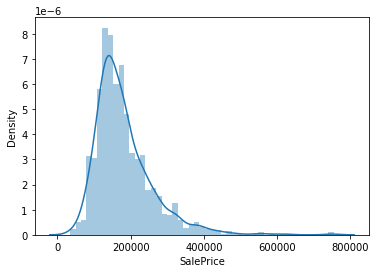

In [5]:
#histogram
sns.distplot(df_train['SalePrice'])

# 3.他の変数との関係を見てみる
heatmapが便利

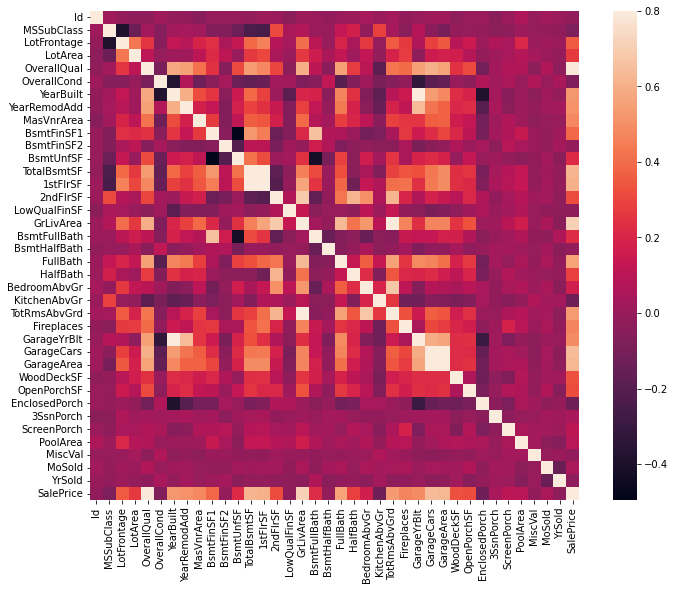

In [6]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

- 'TotalBsmtSF' と '1stFlrSF' 変数、また、Garageなんとか系の変数は相関関係にあることがわかる。多重共線性が発生している。

- また、「GrLivArea」、「TotalBsmtSF」、「OverallQual」は従属変数SalePriceと相関がある。

次は相関が高いものに絞ってheatmapを見てみる

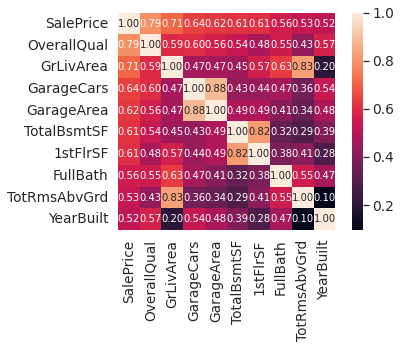

In [7]:
k = 10
# salePriceと相関の高い10個の列名取得
cols = corrmat.nlargest(k, 'SalePrice')["SalePrice"].index
# その列名を列ごとに取り出す
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)

- 'GarageCars'と'GarageArea'は同じようなものか。<br>
- FullBathの相関が高い、本当に、、？<br>
- 「TotRmsAbvGrd」と「GrLivArea」も同じようなものか<br>
- YearBuiltは時系列分析をした方が良いかも知れない。

次に、上から似通った変数を除いて、散布図を描いてみる。

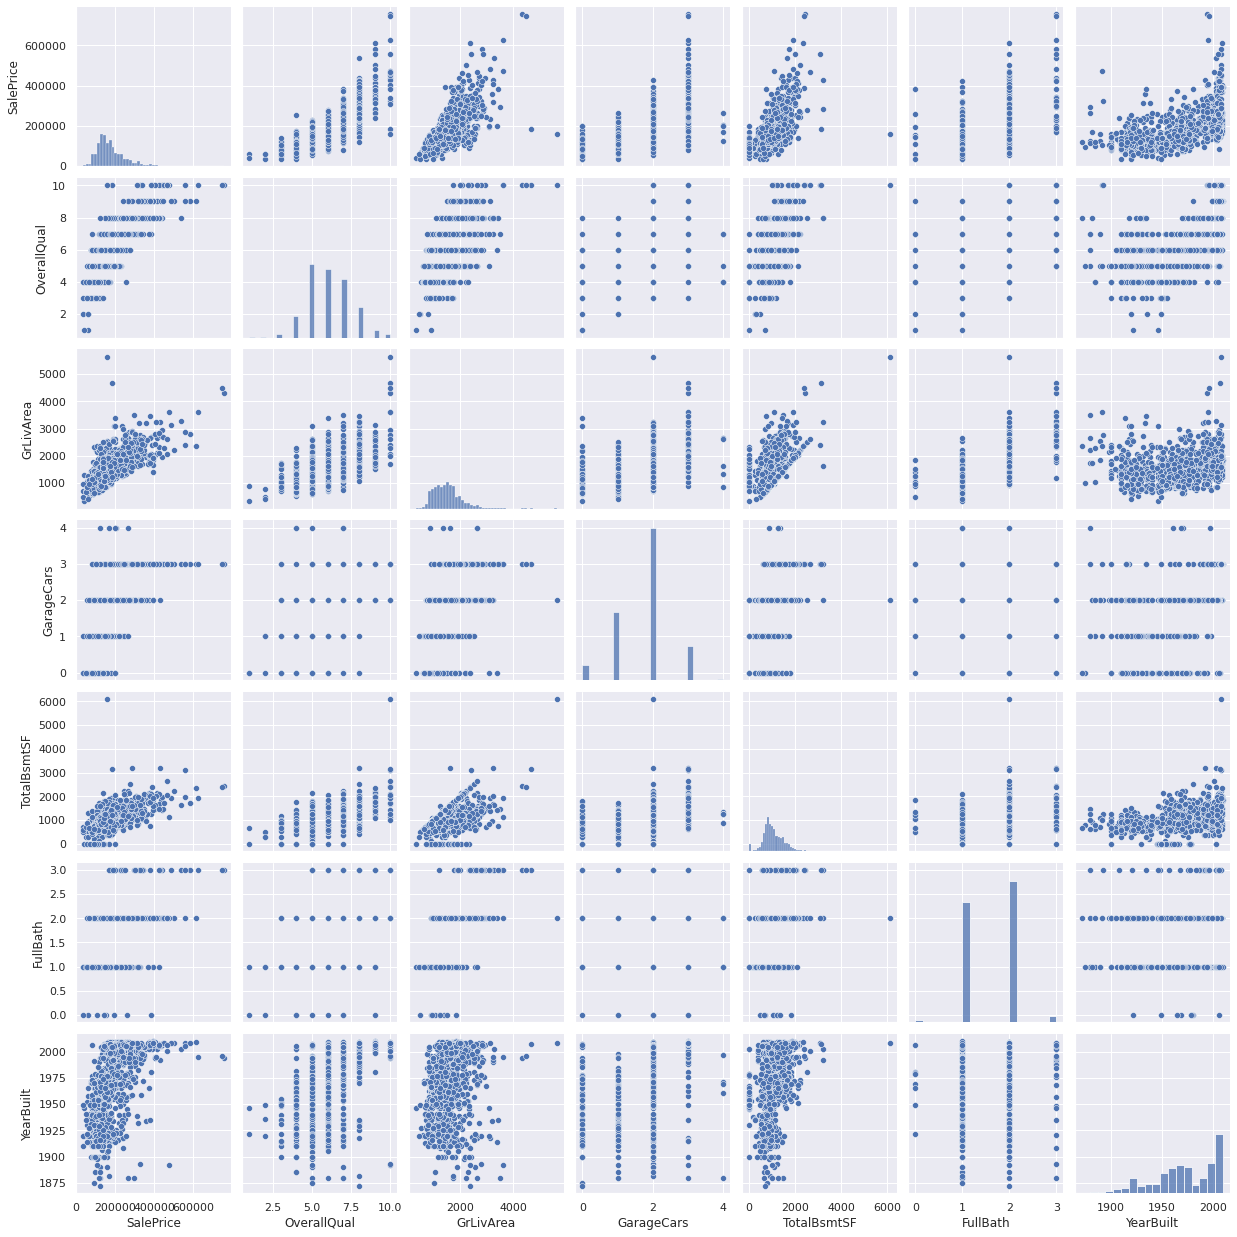

In [8]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

「TotalBsmtSF」と「GrLiveArea」の図は、点が直線的な線を描いており、境界線のように機能している。

# 4.欠損値

欠損値はどの程度あるのか？<br>
欠損はランダムなのか、パターンなのか?<br>

In [9]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


欠損値が15%以上のものは変数ごと削除するべき。<br>
一応欠損値が多いデータを確認してみると、これらの変数のほとんどは家を買う時に考えるような要素ではない。<br>
また、Garage〇〇は全部同じ欠損値を持っている。Garage系ではGarageCarsが一番相関が高かったので、それだけ残してあとは削除する。<br>
同様に、Bsmt〇〇変数に関しても、Totalだけを残す。<br>
'MasVnrArea' と 'MasVnrType'は、既に考慮されているYearBuilt及びOverallQualと強い相関を持っているため、削除しても問題ない。<br>
Electricalに関しては、列ではなく、その行一つを削除する。

纏めると、Electricalは行一つを削除するが、それ以外は特徴量ごと削除する。

In [10]:
new_df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index, axis=1)
new_df_train = new_df_train.drop(df_train.loc[df_train["Electrical"].isnull()].index)
new_df_train.isnull().sum().max() # 処理が正しく行われたかの確認用

0

## 外れ値確認

In [11]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(new_df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


7越えの2つの処遇は考える必要あり。

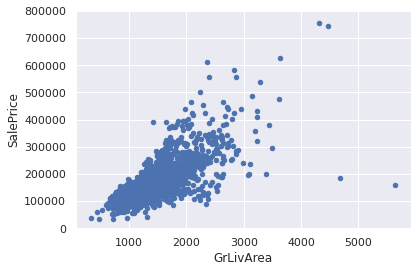

In [12]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([new_df_train['SalePrice'], new_df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

GrLivAreaの外れ値トップ2を削除する

In [13]:
# deleting points
# top2確認
new_df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
# 確認したら、Idが1299と524だった
out_new_df_train = new_df_train.drop(new_df_train[new_df_train['Id'] == 1299].index)
out_new_df_train = new_df_train.drop(out_new_df_train[new_df_train['Id'] == 524].index)

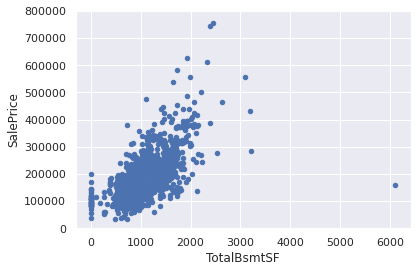

In [14]:
#bivariate analysis saleprice/grlivarea
var = 'TotalBsmtSF'
data = pd.concat([out_new_df_train['SalePrice'], out_new_df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

3000以上の値があるが、外れ値にしなくてもいいと判断した。

# 5.仮説を検証

正規性、線形性、相関性など

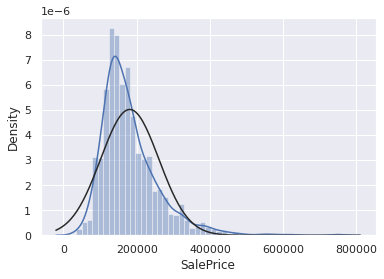

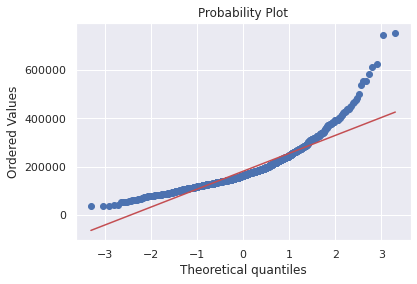

In [15]:
#histogram and normal probability plot
sns.distplot(out_new_df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(out_new_df_train['SalePrice'], plot=plt)

だいぶ左に偏っている(歪度>0)。対数変換して対策する。ついでに、歪度>0.75の列を全て対数変換する。

In [16]:
from scipy.stats import skew

numeric_feats = out_new_df_train.select_dtypes(exclude=["object"]).columns
skewness = out_new_df_train.filter(items=numeric_feats).apply(lambda x: skew(x.dropna()))
skewness = skewness[skewness > 0.75]
skewed_feats = skewness.index
print('----Skewness greater than 0.75----')
print(skewness)


log_df_train = out_new_df_train.filter(items=skewed_feats).applymap(lambda x: np.log1p(x))
log_out_new_df_train = out_new_df_train.copy()
log_out_new_df_train[skewed_feats] = log_df_train

----Skewness greater than 0.75----
MSSubClass        1.406848
LotArea          12.285751
BsmtFinSF1        1.674960
BsmtFinSF2        4.247550
BsmtUnfSF         0.919727
TotalBsmtSF       1.495578
1stFlrSF          1.329021
2ndFlrSF          0.811050
LowQualFinSF      8.995688
GrLivArea         1.273937
BsmtHalfBath      4.095895
KitchenAbvGr      4.480268
WoodDeckSF        1.541494
OpenPorchSF       2.332119
EnclosedPorch     3.083987
3SsnPorch        10.286510
ScreenPorch       4.114690
PoolArea         14.802847
MiscVal          24.434913
SalePrice         1.879467
dtype: float64


どうなったか確認

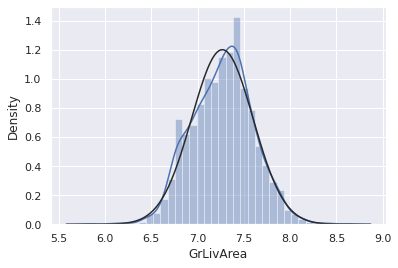

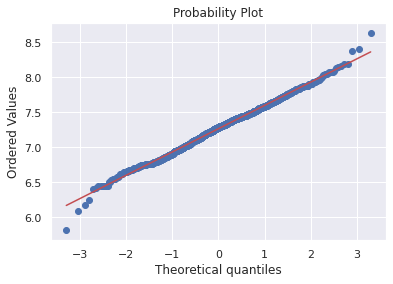

In [17]:
#transformed histogram and normal probability plot
sns.distplot(log_out_new_df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(log_out_new_df_train['GrLivArea'], plot=plt)

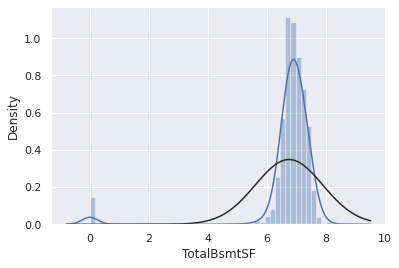

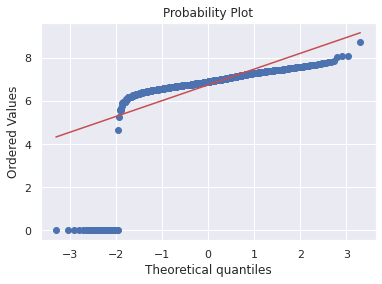

In [18]:
#histogram and normal probability plot
sns.distplot(log_out_new_df_train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(log_out_new_df_train['TotalBsmtSF'], plot=plt)

## 最後に、ダミー変数を作成

In [19]:
df_train_cleaned = pd.get_dummies(log_out_new_df_train, drop_first=True)
# おまけにId列削除
df_train_cleaned = df_train_cleaned.drop("Id", axis=1)

In [20]:
df_train_cleaned

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,9.042040,7,5,2003,2003,6.561031,0.000000,5.017280,6.753438,6.753438,6.751101,0.0,7.444833,1,0.000000,2,1,3,0.693147,8,0,2,548,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.000000,2,2008,12.247699,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,3.044522,9.169623,6,8,1976,1976,6.886532,0.000000,5.652489,7.141245,7.141245,0.000000,0.0,7.141245,0,0.693147,2,0,3,0.693147,6,1,2,460,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.000000,5,2007,12.109016,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0